# Titanic Kaggle competition
> Use attributes to predict which passengers are more likely to survive

This is an attempt a simple solution to the Titanic competetion on Kaggle ([link](https://www.kaggle.com/competitions/titanic/overview)).

In [1]:
import collections
import os

from typing import Any, Tuple

import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '/data/kaggle/titanic'
EDA_DIR = os.path.join(DATA_DIR, 'eda')
TRAIN_FILE = os.path.join(DATA_DIR, 'train.csv')
TEST_FILE = os.path.join(DATA_DIR, 'test.csv')
CROSS_VALIDATION_FOLDS = 5
RANDOM_SEED = 99
TEST_SET_SIZE = 0.2

os.makedirs(EDA_DIR, exist_ok=True)
np.random.seed(RANDOM_SEED)

In [32]:
mlflow.set_tracking_uri("https://mlflow.tenzing.shkhr.ovh")
experiment_id = mlflow.set_experiment('kaggle-titanic')

## Data exploration

Let's take a look at the training data we're given.

In [15]:
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
len(train_df)

891

In [8]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
MissingValueEntry = collections.namedtuple('MissingValueEntry', ['column', 'missing_value_percent'])
pd.DataFrame([MissingValueEntry(col, 100 * train_df[col].isnull().sum() / len(train_df)) for col in train_df.columns])

,column,missing_value_percent
0,PassengerId,0.000000
1,Survived,0.000000
2,Pclass,0.000000
3,Name,0.000000
4,Sex,0.000000
5,Age,19.865320
6,SibSp,0.000000
7,Parch,0.000000
8,Ticket,0.000000
9,Fare,0.000000


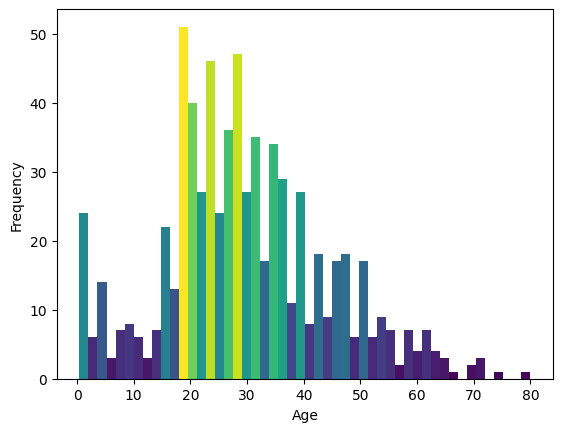

In [10]:
n, bins, patches = plt.hist(train_df['Age'], bins=50)
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i] / max(n)))

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

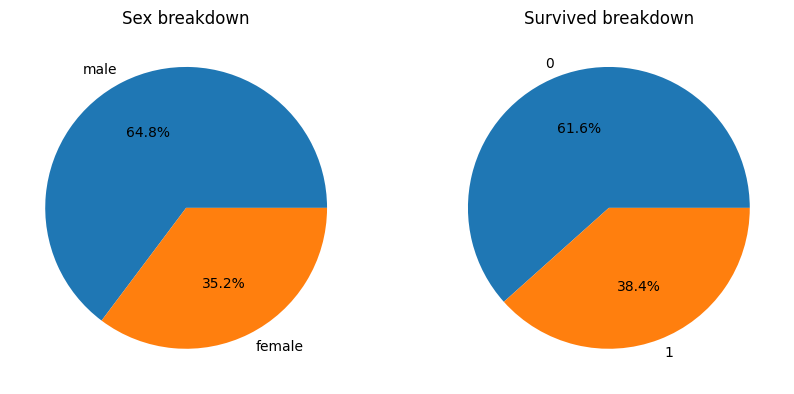

In [11]:
categorical_columns = ['Sex', 'Survived']

charts_per_row = 2
num_rows = int(np.ceil(len(categorical_columns) / charts_per_row))
fig, axs = plt.subplots(num_rows, charts_per_row, figsize=(10, 5))

for idx, col in enumerate(categorical_columns):
    col_counts = train_df[col].value_counts()
    axs[idx].pie(col_counts, labels=col_counts.index, autopct='%1.1f%%')
    axs[idx].set_title(f'{col} breakdown')

### Need for data imputation

It looks like some of these features have `NaN` values. Based on how important those features are, we should decide on a strategy to impute these values to gather as much training data as possible and still be able to perform predictions when such cases arise in the test set.

One of the important features we'd need to look at is 'Age', which could have a large impact on survivability and has 20% values missing.

In [40]:
train_df[train_df['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [41]:
train_df['Title'], test_df['Title'] = [df.Name.str.extract(' ([A-Za-z]+)\.', expand=False) for df in [train_df, test_df]]

In [43]:
train_df.groupby(['Title', 'Pclass'])['Age'].agg(['mean', 'count', 'std'])

mean  count        std
Title    Pclass                             
Capt     1       70.000000      1        NaN
Col      1       58.000000      2   2.828427
Countess 1       33.000000      1        NaN
Don      1       40.000000      1        NaN
Dr       1       43.750000      4   8.261356
         2       38.500000      2  21.920310
Jonkheer 1       38.000000      1        NaN
Lady     1       48.000000      1        NaN
Major    1       48.500000      2   4.949747
Master   1        5.306667      3   5.165475
         2        2.258889      9   2.342634
         3        5.350833     24   3.593608
Miss     1       30.000000     45  12.852308
         2       22.390625     32  13.374708
         3       16.123188     69   9.697315
Mlle     1       24.000000      2   0.000000
Mme      1       24.000000      1        NaN
Mr       1       41.580460     87  14.148275
         2       32.768293     82  11.850977
         3       28.724891    229  10.490946
Mrs      1       40.882353     34  12.643754
         2       33.682927     41  10.318525
         3       33.515152     33  10.031579
Ms       2       28.000000      1        NaN
Rev      2       43.166667      6  13.136463
Sir      1       49.000000      1        NaN

Looks like we're given 891 passengers in the training set, with the following attributes (some of them are self-explanatory):

1. `Pclass`: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
2. `Name`
3. `Sex`
4. `Age`: Age in years
5. `SibSp`: # of siblings / spouses aboard the Titanic
6. `Parch`: # of parents / children aboard the Titanic
7. `Ticket`: Ticket #
8. `Fare`
9. `Cabin`: Cabin number
10. `Embarked`: Port of embarkation (C = Chernbourg, Q = Queenstown, S = Southampton)

## Model 1: Logistic regression on selected attributes

The first model we'll try is to create a basic Logistric regression model which predicts the likelihood of a survival based on a few manually selected attributes.

The attributes we select for this model are: `PClass, Sex, Age, SibSp, Parch`

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [14]:
run = mlflow.start_run(run_name='logistic-regression-v1', description='Training a logistic regression classifier with selected fields: ["Pclass", "Sex_f", "Age", "SibSp", "Parch"], and linear-regression imputation on the sex field.')

In [15]:
class MissingAgeLinearRegressionTransfomer(TransformerMixin, BaseEstimator):
    AGE_COL_IDX = 4

    def __init__(self, regressor=None):
        self.regressor = regressor
    
    def fit(self, X=None, y=None):
        mask = np.isnan(X[:, self.AGE_COL_IDX])
        X_train = X[~mask][:, :self.AGE_COL_IDX]
        y_train = X[~mask][:, self.AGE_COL_IDX]
        
        if self.regressor is None:
            self.regressor = LinearRegression()
        self.regressor.fit(X_train, y_train)

        return self

    def transform(self,  X, y=None):
        mask = np.isnan(X[:, self.AGE_COL_IDX])
        X_pred = X[mask][:, :self.AGE_COL_IDX]
        y_pred = self.regressor.predict(X_pred)

        X_transform = X.copy()
        X_transform[mask, self.AGE_COL_IDX] = y_pred

        return X_transform

In [16]:
passthrough_columns = ['Pclass', 'SibSp', 'Parch', 'Age']
categorical_columns = ['Sex']
imputed_columns = ['Age']

all_columns = list(set(passthrough_columns + categorical_columns + imputed_columns))

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns),
        ('numeric', 'passthrough', passthrough_columns),
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', MissingAgeLinearRegressionTransfomer()),
    ('model', LogisticRegressionCV(cv=CROSS_VALIDATION_FOLDS, random_state=RANDOM_SEED))
])

X = train_df[passthrough_columns + categorical_columns].copy()
y = train_df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SET_SIZE, random_state=RANDOM_SEED)

pipeline.fit(X_train, y_train)
validation_accuracy = pipeline.score(X_val, y_val)
print(validation_accuracy)

mlflow.log_metric('validation_accuracy', validation_accuracy)

0.7932960893854749


In [18]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
predictions_df = test_df.copy()
predictions_df['Survived'] = pipeline.predict(predictions_df)
predictions_path = os.path.join(DATA_DIR, 'predictions', 'logistic-regression-pipeline.csv')

predictions_df[['PassengerId', 'Survived']].to_csv(predictions_path, index=False)
mlflow.log_artifact(predictions_path)

In [19]:
mlflow.log_metric('test_accuracy', 0.77272)

In [20]:
mlflow.end_run()

## Model 2: Random forest classifier on selected attributes

In [22]:
run = mlflow.start_run(run_name='random-forest-v1', description='Training a random forest with selected fields: ["Pclass", "Sex_f", "Age", "SibSp", "Parch"], and linear-regression imputation on the age field.')

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', MissingAgeLinearRegressionTransfomer()),
    ('model', RandomForestClassifier(random_state=RANDOM_SEED))
])

pipeline.fit(X_train, y_train)
validation_accuracy = pipeline.score(X_val, y_val)
print(validation_accuracy)

mlflow.log_metric('validation_accuracy', validation_accuracy)

0.7932960893854749


In [33]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
predictions_df = test_df.copy()
predictions_df['Survived'] = pipeline.predict(predictions_df)
predictions_path = os.path.join(DATA_DIR, 'predictions', 'random-forest-pipeline.csv')

predictions_df[['PassengerId', 'Survived']].to_csv(predictions_path, index=False)
mlflow.log_artifact(predictions_path)

In [34]:
mlflow.log_metric('test_accuracy', 0.73444)

In [35]:
mlflow.end_run()

## Model 3: Logistic regression with better imputation on age

In [13]:
class TitleBasedAgeImputation(TransformerMixin, BaseEstimator):
    def __init__(self, measure='mean'):
        self.measure = measure
    
    def fit(self, X=None, y=None):
        X['Title'] = X.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        self.age_groups = X.groupby(['Title', 'Pclass'])['Age'].agg(['mean', 'count', 'std', 'median'])

        return self

    def transform(self,  X, y=None):
        X_transform = X.copy()

        X_transform['Title'] = X_transform.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        mask = X_transform['Age'].isna()

        def try_get_closest_age(title: str, pclass: int) -> float:
            if not title in self.age_groups[self.measure]:
                return self.age_groups[self.measure].mean()
            
            if not pclass in self.age_groups[self.measure][title]:
                return self.age_groups[self.measure][title].mean()

            return self.age_groups[self.measure][title][pclass]

        X_transform.loc[mask, 'Age'] = X_transform[mask].apply(lambda x: try_get_closest_age(x['Title'], x['Pclass']), axis=1)

        return X_transform

In [64]:
run = mlflow.start_run(run_name='logistic-regression-v2', description='Logistic regression v1 with better imputation for age, based on passenger names.')

In [84]:
pipeline = Pipeline(steps=[
    ('imputer', TitleBasedAgeImputation(measure='median')),
    ('preprocessor', preprocessor),
    ('model', LogisticRegressionCV(cv=CROSS_VALIDATION_FOLDS, random_state=RANDOM_SEED))
])


X = train_df[passthrough_columns + categorical_columns + ['Name']].copy()
y = train_df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SET_SIZE, random_state=RANDOM_SEED)

pipeline.fit(X_train, y_train)
validation_accuracy = pipeline.score(X_val, y_val)
print(validation_accuracy)

mlflow.log_metric('validation_accuracy', validation_accuracy)

0.7653631284916201


In [86]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
predictions_df = test_df.copy()
predictions_df['Survived'] = pipeline.predict(predictions_df)
predictions_path = os.path.join(DATA_DIR, 'predictions', 'logistic-regression-title-based-age.csv')

predictions_df[['PassengerId', 'Survived']].to_csv(predictions_path, index=False)
mlflow.log_artifact(predictions_path)

In [87]:
mlflow.log_metric('test_accuracy', 0.75837)

In [88]:
mlflow.end_run()

## Model 4: Random forest + CV + named based age imputation

In [89]:
from sklearn.model_selection import GridSearchCV

In [97]:
run = mlflow.start_run(run_name='random-forest-v2', description='Random forest v1 with better imputation for age, based on passenger names, along with GridSearchCV')

In [ ]:
rfc_pipeline = Pipeline(steps=[
    ('imputer', TitleBasedAgeImputation(measure='median')),
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_SEED))
])


X = train_df[passthrough_columns + categorical_columns + ['Name']].copy()
y = train_df['Survived']

param_grid = {
    'model__n_estimators': [20, 50, 100],
    'model__max_depth': [7, 10, None],
    'model__min_samples_split': [5, 10, 20],
    'model__min_samples_leaf': [2, 4],
    'model__max_features': ['sqrt', 'log2', None]}

grid_search = GridSearchCV(rfc_pipeline, param_grid, cv=CROSS_VALIDATION_FOLDS, n_jobs=-1)
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

mlflow.log_metric('validation_accuracy', grid_search.best_score_)

test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
predictions_df = test_df.copy()
predictions_df['Survived'] = grid_search.predict(predictions_df)
predictions_path = os.path.join(DATA_DIR, 'predictions', 'random-forest-v2.csv')

predictions_df[['PassengerId', 'Survived']].to_csv(predictions_path, index=False)
mlflow.log_artifact(predictions_path)

Best Hyperparameters: {'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 50}
Best Score: 0.833927562613772


In [102]:
mlflow.log_metric('test_accuracy', 0.7488)

In [103]:
mlflow.end_run()

## Model 5: Random forest + CV + named based age imputation + extra features

In [112]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [118]:
run = mlflow.start_run(run_name='random-forest-v3', description='Random forest v1 with better imputation for age, based on passenger names, along with GridSearchCV')

In [119]:

selected_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Name']
target = 'Survived'

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, ['Age', 'SibSp', 'Parch', 'Fare']),
    ('cat', categorical_transformer, ['Pclass', 'Sex', 'Embarked'])
])

rfc_pipeline = Pipeline(steps=[
    ('imputer', TitleBasedAgeImputation(measure='mean')),
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_SEED))
])


X = train_df[selected_features].copy()
y = train_df[target]

param_grid = {
    'model__n_estimators': [20, 50, 100],
    'model__max_depth': [7, 10, None],
    'model__min_samples_split': [5, 10, 20],
    'model__min_samples_leaf': [2, 4],
    'model__max_features': ['sqrt', 'log2', None]}

grid_search = GridSearchCV(rfc_pipeline, param_grid, cv=CROSS_VALIDATION_FOLDS, n_jobs=-1)
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

mlflow.log_metric('validation_accuracy', grid_search.best_score_)

test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
predictions_df = test_df.copy()
predictions_df['Survived'] = grid_search.predict(predictions_df)
predictions_path = os.path.join(DATA_DIR, 'predictions', 'random-forest-v3.csv')

predictions_df[['PassengerId', 'Survived']].to_csv(predictions_path, index=False)
mlflow.log_artifact(predictions_path)

Best Hyperparameters: {'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Best Score: 0.8350386039796623


In [120]:
mlflow.log_metric('test_accuracy', 0.78229)

In [121]:
mlflow.end_run()

## Model 6: Custom imputation + feature engineering

In [33]:
def custom_imputation(input_df: pd.DataFrame):
    output_df = input_df.copy()
    output_df['Embarked'] = output_df['Embarked'].fillna('S')
    output_df['Deck'] = output_df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    
    # Move the lone T deck passenger to A.
    idx = output_df[output_df['Deck'] == 'T'].index
    output_df.loc[idx, 'Deck'] = 'A'

    output_df['Deck'] = output_df['Deck'].replace(['A', 'B', 'C'], 'ABC')
    output_df['Deck'] = output_df['Deck'].replace(['D', 'E'], 'DE')
    output_df['Deck'] = output_df['Deck'].replace(['F', 'G'], 'FG')

    output_df.drop(['Cabin'], inplace=True, axis=1)

    return output_df

In [34]:
run = mlflow.start_run(run_name='random-forest-v4', description='Training a random forest with custom imputation and feature engineering logic.')

In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

class CustomImputer(TransformerMixin, BaseEstimator):

    def fit(self, X=None, y=None):
        
        return self

    def transform(self,  X, y=None):
        return custom_imputation(X)

class CustomFeatureEng(TransformerMixin, BaseEstimator):

    non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

    def fit(self, X=None, y=None):
        _, self.fare_bins = pd.qcut(X['Fare'], q=13, retbins=True)
        _, self.age_bins = pd.qcut(X['Age'], q=10, retbins=True)

        return self
    

    def transform(self,  X: pd.DataFrame, y=None):
        X_transform = X.copy()
        X_transform['Fare'] = pd.cut(X_transform['Fare'], self.fare_bins)
        X_transform['Age'] = pd.cut(X_transform['Age'], self.age_bins)

        X_transform['Family_Size'] = X_transform['SibSp'] + X_transform['Parch'] + 1
        family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
        X_transform['Family_Size_Grouped'] = X_transform['Family_Size'].map(family_map)

        X_transform['Ticket_Frequency'] = X_transform.groupby('Ticket')['Ticket'].transform('count')

        X_transform['Is_Married'] = 0
        X_transform['Is_Married'].loc[X_transform['Title'] == 'Mrs'] = 1

        return X_transform

In [36]:

selected_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Name', 'Cabin', 'Ticket']

non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']

target = 'Survived'

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features)
])

rfc_pipeline = Pipeline(steps=[
    ('age_imputer', TitleBasedAgeImputation(measure='mean')),
    ('custom_imputation', CustomImputer()),
    ('custom_feature_eng', CustomFeatureEng()),
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_SEED))
])

X = train_df[selected_features].copy()
y = train_df[target]

param_grid = {
    'model__n_estimators': [20, 200, 2000],
    'model__max_depth': [5, 7, 10],
    'model__min_samples_split': [4],
    'model__min_samples_leaf': [5],
    'model__max_features': ['sqrt'],
    'model__criterion': ['gini']
}

grid_search = GridSearchCV(rfc_pipeline, param_grid, cv=CROSS_VALIDATION_FOLDS, n_jobs=-1)
grid_search.fit(X, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

mlflow.log_metric('validation_accuracy', grid_search.best_score_)


/tmp/ipykernel_9495/1593677483.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_9495/1593677483.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_9495/1593677483.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_9495/1593677483.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

Best Hyperparameters: {'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 4, 'model__n_estimators': 2000}
Best Score: 0.8305128366078716


In [37]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
predictions_df = test_df.copy()
predictions_df['Survived'] = grid_search.predict(predictions_df)
predictions_path = os.path.join(DATA_DIR, 'predictions', 'random-forest-v4.csv')

predictions_df[['PassengerId', 'Survived']].to_csv(predictions_path, index=False)
mlflow.log_artifact(predictions_path)

/tmp/ipykernel_9495/1593677483.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_transform['Is_Married'].loc[X_transform['Title'] == 'Mrs'] = 1
/home/shikhar/.pyenv/versions/3.10.6/envs/kaggle/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [30]:
mlflow.log_metric('test_accuracy', 0.78229)

In [31]:
mlflow.end_run()